# CSCI E-81 Machine Learning and Data Mining: Homework 5
**Harvard University**<br>
**Fall 2016**<br>
**Team: Nirmal Labh, Anmol Joshi**<br>
**Due Date: ** Monday, November 21st, 2016 at 11:59pm<br>
**Submission Date: ** Tuesday, November 22nd, 2016 [using 1 day grace period]

## Classification and Clustering of plays by William Shakspeare

William Shakespeare is considered one of the greatest playwrights in the English language. He is attributed with 38 plays, 154 sonnets, and other works. Even 400 years later, his writings are still be studied in most high schools and colleges in the US and elsewhere. Shakespeare’s complete works are available online at http://shakespeare.mit.edu/
With so many comedies, tragedies and historical plays, he created casts of characters from kings and queens to heroes and villains, and we can’t ignore the fools. Your task is to use machine learning/data mining/text mining techniques on the language of Shakespeare’s works to examine the similarities/differences in the characters based on their language. You should examine these similarities or differences using a few clustering techniques on the words uttered by the characters perhaps individually but more likely per scene/act and (for minor characters) by play. You can visualize the results by play, gender, role, etc. from the clustered data. The clustering is intended to include all the plays in one clustering (at least initially) so as to be able to compare characters across plays.

---
### For classification and clustering, we will use below:

<ul>
<li> tokenizing and stemming each utterance/document
<li> transforming the corpus into vector space using **tf-idf**
<li> calculating cosine distance between each document as a measure of similarity
<li> clustering the documents using the **k-means** algorithm
<li> using *multidimensional scaling* to reduce dimensionality within the corpus
<li> plotting the clustering output
<li> conducting a hierarchical clustering on the corpus using **Ward clustering**
<li> plotting a **Ward dendrogram**
<li> exploring clustering using **Naïve Bayes classifier**
</ul>


The purpose of this homework was to analyze the works of Shakespeare using Machine Learning techniques we have learned in class. This involved downloading his 37 plays from https://shakespeare.mit.edu/ and clustering the text data based on play genres and characters for all of the plays; for the analysis of characters we clustered based on gender. The analysis we used was both unsupervised learning methods and supervised learning methods to test the accuracy of the classifiers and just how they cluster the data. For unsupervised learning methods, we used k-means and for supervised learning methods, we used Naive Bayes Classifier. We use Naïve Bayes in the exploratory section for this homework. 

The 37 plays had three different genres with 17 Comedy, 10 History and 10 Tragedy, we ignored Poetry and Sonnets for this homework. Shakespeare is one of the most studied authors in history, we hope we are able to replicate this literary analysis using Machine Learning techniques. Shakespeare is admired for his writing style, especially for the themes and motifs of his plays and how his characters are written. Given his distinct writing styles, we hope that we can create a classifier that can classify the plays and characters. How do we expect this to work? How we expect this clustering to work is that there are significant similarities between genres, genders and character types meaning that there are features of text specific to men, women, comedies, history, tragedies.


** IMPORTANT:
All data files for the plays obtained using the http get request are being saved
in local file in directory/filder 'data' in the current directory from where we run 
our python notebook code.**

**This helps avoid http pull traffic each time we execute the code. **

**Additionally, we found '< p >' html tag missing in below three plays as compared to remaining 34 plays:**

   **Henry IV, part 2**

   **Othello**

  ** Pericles**

**We edited the local file to add the missing '< p >' tag, so as to not over complicate the code for scraping html data.**

---
#### Reading Data from MIT Site:

In [1]:
import os
import urllib.request

from IPython.core.display import HTML
HTML('<a href="http://shakespeare.mit.edu">link</a>')

# http request to get the main html page that we are saving in 
# local file to avoid http pull traffic each time we execute the code
main_url = 'http://shakespeare.mit.edu'
main_file = 'data/main.html'
if not os.path.isfile(main_file):
    print('HTTP request to get play list ...\n')
    with urllib.request.urlopen(main_url) as req:
        main_page = req.read().decode()
        with open(main_file, 'w') as f:
            f.write(main_page)
else:
    with open(main_file, 'r') as f:
        main_page = f.read()

        
image_link = 'http://shakespeare.mit.edu/shake.gif'
gif_file = 'shake.gif'

if not os.path.isfile(gif_file):
    resource = urllib.request.urlopen(image_link)
    output = open(gif_file,"wb")
    output.write(resource.read())
    output.close()

    
from IPython.core.display import display, HTML
display(HTML(main_file))

Comedy,History,Tragedy,Poetry
"All's Well That Ends Well As You Like It The Comedy of Errors Cymbeline Love's Labours Lost Measure for Measure The Merry Wives of Windsor The Merchant of Venice A Midsummer Night's Dream Much Ado About Nothing Pericles, Prince of Tyre Taming of the Shrew The Tempest Troilus and Cressida Twelfth Night Two Gentlemen of Verona Winter's Tale","Henry IV, part 1 Henry IV, part 2 Henry V Henry VI, part 1 Henry VI, part 2 Henry VI, part 3 Henry VIII King John Richard II Richard III",Antony and Cleopatra Coriolanus Hamlet Julius Caesar King Lear Macbeth Othello Romeo and Juliet Timon of Athens Titus Andronicus,The Sonnets A Lover's Complaint The Rape of Lucrece Venus and Adonis Funeral Elegy by W.S.


### Importing all modules used:

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction

import os
import re
import time
import json
import roman
import urllib.request
from bs4 import BeautifulSoup

## 1) Data preparation technique(s): 

### To convert the text to features. You will use all of Shakespeare’s plays (comedy, history, tragedy) but can skip the sonnets (poetry). Each character’s utterances should be captured in a row of the data table possibly separately, but more likely grouped by scene, act, or possibly even work.
---

We start this problem by extracting all the text of the plays and concatenating it into one line, so the result is a data frame with 2 columns, one index contains all the play names and the other column contains all the text of the play. We do the same for each of the characters of the plays, creating a data frame of 3 columns. For the first column, we list the plays and the second column is the speaker for said play, with the last column is all the lines spoken by this character concatenated. We were provided with a list of characters of all of the plays, with some details such as Play, Number of Lines, Gender, Top Villain and Fools. To add gender for each of the characters as labels to check later and to compare with the text file, we capitalize the names of the characters.

#### Data Preparation: 

Converting the text to features, using all of Shakespeare’s plays (comedy, history, tragedy) and *skipping the sonnets (poetry)*. Each *character’s utterances* is being captured in a row of the data table separately, *grouped by play, scene, act, utterance line and the character*.

In [3]:
# extracting all plays - comedy, history and tragedy
soup = BeautifulSoup(main_page, 'html.parser')
tables = soup.findAll('table')

rows = tables[1].findAll("tr")
cells = rows[1].findAll("td")

plays = {}
plays_class = []
for cell in range(3):
  for href in cells[cell].findAll("a"):
      ref = href.string.replace('\n', ' ').lstrip(' ')
      play = href['href'].split('/')[0]
      plays[ref] = play
      plays_class.append({'play': ref, 'class': cell})


print("Number of plays scraped [source: %s]: %s\n" % (main_url, len(plays.keys())))
for i, pkey in enumerate(plays.keys()):
    print("%-30s [class: %s]: %s" % (pkey, plays_class[i]['class'], plays[pkey]))

Number of plays scraped [source: http://shakespeare.mit.edu]: 37

As You Like It                 [class: 0]: asyoulikeit
Henry VIII                     [class: 0]: henryviii
King Lear                      [class: 0]: lear
Coriolanus                     [class: 0]: coriolanus
Henry IV, part 2               [class: 0]: 2henryiv
Twelfth Night                  [class: 0]: twelfth_night
Julius Caesar                  [class: 0]: julius_caesar
Troilus and Cressida           [class: 0]: troilus_cressida
Measure for Measure            [class: 0]: measure
Two Gentlemen of Verona        [class: 0]: two_gentlemen
King John                      [class: 0]: john
Hamlet                         [class: 0]: hamlet
Much Ado About Nothing         [class: 0]: much_ado
The Merry Wives of Windsor     [class: 0]: merry_wives
Love's Labours Lost            [class: 0]: lll
Henry IV, part 1               [class: 0]: 1henryiv
Cymbeline                      [class: 0]: cymbeline
The Merchant of Venice         [c

In [4]:
# iterating thru'all 37 plays, downloading the html content, scraping the text
# as rows of the dataframe, with play, scene, act and the character for each line of utterance  

base_url = 'http://shakespeare.mit.edu/'

lineblocks = []

for pkey in plays.keys():    
    play = plays[pkey]

    url = base_url + plays[pkey].replace('index.html','full.html')
    local_file = 'data/' + play + '.html'

    if not os.path.isfile(local_file):
        print('Making http request...')
        with urllib.request.urlopen(url) as req:
            page = req.read().decode()
            with open(local_file, 'w') as f:
                f.write(page)
    else:
        #print('Using locally saved file...')
        with open(local_file, 'r') as f:
            page = f.read()
            
            
    soup = BeautifulSoup(page, 'html.parser')

    r = re.compile('(?P<type>SCENE|ACT)\s(?P<num>[IVX]+)\.?\s?(?P<desc>[\s\S]+)?')


    last = soup.find('h3')
    act, scene = None, None

    #looking for lines...
    while last:
      # find act / scene headers
      if last.text != 'PROLOGUE':
        m = r.match(last.text)
        num = m.group('num')
        n = roman.fromRoman(num)

        if m.group('type') == 'ACT':
            act = n # act number

        elif m.group('type') == 'SCENE':
            # create new scene
            scene = n               # scene number
            desc = m.group('desc')  # description

            # for finding by NAME=1.2.3
            text = '.'.join(['(?P<act>{})'.format(act), '(?P<scene>{})'.format(scene)]) + '\.(?P<line>\d+)'
            numre = re.compile(text)
            # for finding by NAME=speech1,2,3,4.....
            spere = re.compile('speech\d+')

            # find next speaker
            speaker_elem = last.find_next_sibling('p').find('a', {'name':spere})
            while speaker_elem:
                speaker = speaker_elem.b.text.upper() # speaker name

                if speaker == 'Scene III': # wierd bug in html
                    scene = 3
                    text = '.'.join(['(?P<act>{})'.format(act), '(?P<scene>{})'.format(scene)]) + '\.(?P<line>\d+)'
                    numre = re.compile(text)
                else:
                    block = speaker_elem.find_next_sibling('blockquote')
                    if block:
                        lines_raw = block.find_all('a', {'name':numre})
                        line_text = ''
                        line_num = 0 
                        for line in lines_raw:  
                            if line_num == 0:
                               line_num = line['name'].split('.')[2]
                            line_text = line_text + ' ' + line.text.strip()
                        lineblocks.append({'play': pkey, 'scene': scene, 'act': act, 'line_num' : line_num,
                                            'speaker': speaker, 
                                            'line_text':line_text})
    

                speaker_elem = speaker_elem.find_next_sibling('a', {'name':spere})

      last = last.find_next('h3')

lines_df = pd.DataFrame(lineblocks)

In [5]:
# total number of utterances (lines/sentences)
print('Total number of utterances/sentences: ', len(lines_df.index))

# first 20 lines utterances in the play
print('\nFirst 5 lines of utterances/sentences:\n', 
      lines_df.head(5)[['play', 'act','scene','line_num','speaker','line_text']])

Total number of utterances/sentences:  31229

First 5 lines of utterances/sentences:
              play  act  scene line_num  speaker  \
0  As You Like It  1.0      1        1  ORLANDO   
1  As You Like It  1.0      1       26     ADAM   
2  As You Like It  1.0      1       27  ORLANDO   
3  As You Like It  1.0      1       29   OLIVER   
4  As You Like It  1.0      1       30  ORLANDO   

                                           line_text  
0   As I remember, Adam, it was upon this fashion...  
1              Yonder comes my master, your brother.  
2   Go apart, Adam, and thou shalt hear how he wi...  
3                      Now, sir! what make you here?  
4        Nothing: I am not taught to make any thing.  


In [6]:
play_df = pd.DataFrame(lines_df.groupby('play')['line_text'].apply(sum))
play_df.reset_index(level=0, inplace=True)
play_df.rename(columns={'line_text': 'play_text'}, inplace=True)
play_df.head()

,play,play_text
0,A Midsummer Night's Dream,"Now, fair Hippolyta, our nuptial hour Draws o..."
1,All's Well That Ends Well,"In delivering my son from me, I bury a second..."
2,Antony and Cleopatra,"Nay, but this dotage of our general's O'erflo..."
3,As You Like It,"As I remember, Adam, it was upon this fashion..."
4,Coriolanus,"Before we proceed any further, hear me speak...."


In [7]:
speaker_df = pd.DataFrame(lines_df.groupby(['play','speaker'])['line_text'].apply(sum)).reset_index()
#speaker_df.reset_index(level=0, inplace=True)
speaker_df.rename(columns={'line_text': 'speaker_text'}, inplace=True)
speaker_df.head()

,play,speaker,speaker_text
0,A Midsummer Night's Dream,ALL,"That would hang us, every mother's son. Where..."
1,A Midsummer Night's Dream,BOTTOM,"You were best to call them generally, man by ..."
2,A Midsummer Night's Dream,COBWEB,And I. Hail! Cobweb.
3,A Midsummer Night's Dream,DEMETRIUS,"Relent, sweet Hermia: and, Lysander, yield Th..."
4,A Midsummer Night's Dream,EGEUS,"Happy be Theseus, our renowned duke! Full of ..."


In [8]:
# reading in the character classification support file provided in the assignment

character_file = 'Shakespeare_characters.txt'

import chardet
import pandas as pd

with open(character_file, 'rb') as f:
    result = chardet.detect(f.read())  # or readline if the file is large

character_df = pd.read_csv(character_file, encoding=result['encoding'], delimiter='\t')
del(character_df['Unnamed: 1'])
character_df.columns

character_df['Speaker'] = character_df['Speaker'].apply(lambda x: x.upper())

In [9]:
# display all of the villains
character_df[character_df['TopVillain'] == 'yes']

,Speaker,Gender,#Lines,Play,TopVillain,Fools
1,IAGO,Male,1088,Othello,yes,NaN
10,MACBETH,Male,715,Macbeth,yes,NaN
13,RICHARD,Male,685,Richard III,yes,NaN
65,AARON,Male,357,Titus Andronicus,yes,NaN
94,EDMUND,Male,307,King Lear,yes,NaN
111,CYMBELINE,Male,290,Cymbeline,yes,NaN
139,TAMORA,Female,257,Titus Andronicus,yes,NaN
190,REGAN,Female,190,King Lear,yes,NaN
306,CORNWALL,Male,109,King Lear,yes,NaN
377,ANGELO,Male,77,The Comedy of Errors,yes,NaN


In [10]:
# display all of the fools
character_df[character_df['Fools'] == 'fool']

,Speaker,Gender,#Lines,Play,TopVillain,Fools
18,FALSTAFF,Male,641,Henry IV Part 2,NaN,fool
21,FALSTAFF,Male,602,Henry IV Part 1,NaN,fool
95,FESTE,Male,306,Twelfth Night,NaN,fool
110,AUTOLYCUS,Male,291,The Winter's Tale,NaN,fool
114,THERSITES,Male,283,Troilus and Cressida,NaN,fool
115,TOUCHSTONE,Male,283,As You Like It,NaN,fool
140,BOTTOM,Male,255,A Midsummer Night's Dream,NaN,fool
151,FOOL,Male,227,King Lear,NaN,fool
173,PUCK,Male,206,A Midsummer Night's Dream,NaN,fool
177,LAUNCE,Male,201,The Two Gentlemen of Verona,NaN,fool


### Processing for stopwords, stemming, and tokenizing:

We then created a corpus of all the text from the plays in the following manner. We used the NLTK package to extract all of the stopwords in the English directory for example I, me, myself, at, the, you, our, etc. We also take advantage of NLTK Snowball Stemmer to apply to the data. For our analysis, we created a corpus in two ways, one where we just tokenize the words remove any not alphabets and punctuation, and the second where we both tokenize and stem the data. We then create dictionary or vocabulary of the data and examine it to see if it has behaved as we hoped. As we had expected, the vocabulary works just as we had proposed.

We process the utterances for ** stopwords **, then perform **stemming**, and then do **tokenization** using the list of English stop words in **NLTK** python module.

In [11]:
# initializing variable with nltk's English stopwords
stopwords = nltk.corpus.stopwords.words('english')

In [12]:
print(stopwords[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your']


Importing the **Snowball Stemmer** from NLTK for subsequent processing of the *words down into their root*.

In [13]:
# initializing variable with nltk's SnowballStemmer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

#### Below function tokenizes and splits the utterance into a list of its respective words (or tokens) and also stems each token.

In [14]:
# tokenizer and stemmer function - returns the set of stems in the text input
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's 
    tokens = [word for word in nltk.word_tokenize(text)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

####  Next, we use the stemming/tokenizing functions to iterate over the list of utterances to create the stemmed vocabulary:

In [15]:
# iterate over all play and corresponding text
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in play_df['play_text']:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

#### Using these two lists, we are creating a pandas DataFrame with the stemmed vocabulary as the index and the tokenized words as the column.

In [16]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('Number of items in the vocabulary list: ',  vocab_frame.shape[0])

Number of items in the vocabulary list:  816221


#### Looking up the vocabulary and the stemmed word.

In [17]:
print(vocab_frame.head())
print(totalvocab_stemmed[0:50])
print(totalvocab_tokenized[0:50])

               words
now              now
fair            fair
hippolyta  hippolyta
our              our
nuptial      nuptial
['now', 'fair', 'hippolyta', 'our', 'nuptial', 'hour', 'draw', 'on', 'apac', 'four', 'happi', 'day', 'bring', 'in', 'anoth', 'moon', 'but', 'o', 'methink', 'how', 'slow', 'this', 'old', 'moon', 'wane', 'she', 'linger', 'my', 'desir', 'like', 'to', 'a', 'step-dam', 'or', 'a', 'dowag', 'long', 'wither', 'out', 'a', 'young', 'man', 'revenu', 'four', 'day', 'will', 'quick', 'steep', 'themselv', 'in']
['now', 'fair', 'hippolyta', 'our', 'nuptial', 'hour', 'draws', 'on', 'apace', 'four', 'happy', 'days', 'bring', 'in', 'another', 'moon', 'but', 'o', 'methinks', 'how', 'slow', 'this', 'old', 'moon', 'wanes', 'she', 'lingers', 'my', 'desires', 'like', 'to', 'a', 'step-dame', 'or', 'a', 'dowager', 'long', 'withering', 'out', 'a', 'young', 'man', 'revenue', 'four', 'days', 'will', 'quickly', 'steep', 'themselves', 'in']


---
## 2) Solution to include:

### A few tuned clustering techniques with the goal of characterizing similarities and differences between characters as a function of play, gender, role, etc. Be sure to assess/optimize the method as appropriate given the algorithm (i.e., how did you select the “k” of k-means). We have included a text file that lists the gender, play, and some character roles (villain, fool, etc.)

Now let’s explore how we started with the data analysis portion of this homework. After having created a vocabulary of all the words, we vectorize the vocabulary using tf-idf that is Term Frequency – Inverse Document Frequency. This method allocates feature importance to the words, where the importance of a word is directly proportional to the number of occurrences in the document the tf-idf transformation is applied to, but it is inversely proportional to frequency of the vocabulary across documents, this prevents words that occur very frequently to gain importance such as articles, propositions, pronouns, etc. For our tf-idf, we set a minimum and maximum frequency of a word occurrence and remove any stopwords in the English language so as to gain a better matrix to work with.  In the process of computing the TF-IDF, we are makings of n-gram. The Google n-Grams corpus contains part-of-speech tags that enable us to distinguish usage. It becomes a lot more interesting when we distinguish between "well" as a noun (an oil well or an artesian well, for example) and the use of "well", in well, any other context where a tangible entity is not being referred to. [Reference: http://trimc-nlp.blogspot.com/2013/04/tfidf-with-google-n-grams-and-pos-tags.html]

Once we have created a model for vectorizing, we vectorize both the play and speaker data.tf-idf transformation, transforms text arrays into sparse matrices. Now we have a numerical representation of all the text data, which we can use to calculate similarities and differences based on difference metrics. 

---
### Computing the TF-IDF:

#### Here, we are computing the term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the *play_text* list into a tf-idf matrix. 

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.85, max_features=400000,
                                 min_df=0.15, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,4))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(play_df['play_text']) #fit the vectorizer to play text

CPU times: user 32 s, sys: 764 ms, total: 32.7 s
Wall time: 33 s


In [19]:
print('Shape: ', tfidf_matrix.shape)
print('\nSparse Matrix:')
print(tfidf_matrix[0,:20])

Shape:  (37, 7168)

Sparse Matrix:
  (0, 0)	0.0112549704781
  (0, 18)	0.0157005283583
  (0, 15)	0.0157005283583
  (0, 13)	0.0125565653363


### Terms:  
**The list of the features used in the tf-idf matrix, which is the complete vocabulary for the analysis.**

In [20]:
terms = tfidf_vectorizer.get_feature_names()
print(len(terms))
print(terms[:10])

7168
["'a", "'d 'd", "'d 's", "'d 't", "'d ala", "'d ani", "'d arm", "'d away", "'d bear", "'d becaus"]


### Clustering using K-Means:

Using the tf-idf matrix, we run the **k-means** clustering algorithms to find clustering/similarity within the plays. 

Each play is assigned to a cluster. 

Several runs of the algorithm would be required to converge a global optimum as k-means is susceptible to reaching local optima. 

In [21]:
from sklearn.cluster import KMeans

num_clusters = 3

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 2.13 s, sys: 19.9 ms, total: 2.15 s
Wall time: 1.13 s


In [22]:
print(clusters[2:5])

[1, 0, 0]


---
#### Converting play list and clustering dictionaries to Pandas DataFrame.

In [23]:
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

pd_clusters = pd.DataFrame(clusters, columns = ['cluster'])

pd_plays_class = pd.DataFrame(plays_class)

all_plays_cluster = pd.concat([play_df, pd_clusters], axis=1)[['play','cluster']]
all_plays_frame = pd.merge(all_plays_cluster, pd_plays_class, on='play')[['play','cluster','class']]

print(all_plays_frame.sort('class')[['play','cluster','class',]] )

                          play  cluster  class
0    A Midsummer Night's Dream        0      0
34               Twelfth Night        0      0
33        Troilus and Cressida        0      0
30                 The Tempest        0      0
29  The Merry Wives of Windsor        0      0
28      The Merchant of Venice        0      0
27        The Comedy of Errors        0      0
26         Taming of the Shrew        0      0
22    Pericles, Prince of Tyre        0      0
20      Much Ado About Nothing        0      0
19         Measure for Measure        0      0
35     Two Gentlemen of Verona        0      0
17         Love's Labours Lost        0      0
36               Winter's Tale        0      0
3               As You Like It        0      0
5                    Cymbeline        0      0
1    All's Well That Ends Well        0      0
7             Henry IV, part 1        2      1
13                  Henry VIII        0      1
24                 Richard III        2      1
23           

In [24]:
#groupby cluster for aggregation purposes
grouped_by_cluster = all_plays_frame['play'].groupby(all_plays_frame['cluster']) 

#groupby cluster for aggregation purposes
grouped_by_class = all_plays_frame['play'].groupby(all_plays_frame['class']) 


print('Origninal group count: ', grouped_by_class.count()) #counts per cluster
print('\nClustering group count: ', grouped_by_cluster.count()) #counts per cluster

Origninal group count:  class
0    17
1    10
2    10
Name: play, dtype: int64

Clustering group count:  cluster
0    26
1     2
2     9
Name: play, dtype: int64


In [25]:
all_plays_frame['play'].groupby([all_plays_frame['cluster'],all_plays_frame['class']]) .count().reset_index()

,cluster,class,play
0,0,0,17
1,0,1,1
2,0,2,8
3,1,2,2
4,2,1,9


Note that **clusters** counts based on our clustering is *not quite matching the counts* for the **three groups**: 
* Comedy
* History
* Tragedy

In [26]:
all_plays_frame.ix[2]['play']

'Antony and Cleopatra'

In [27]:
print("Top terms per cluster:", end='')
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    play_i = all_plays_frame.ix[i]['play']

    # below line gets us the play by name for the indexes 0, 1, 2, but we 
    # wuld like to have the ones that are centeroid
    print("\nCluster %d\n  Play: %s" % (i, play_i))
    print("  Top Terms:", end='')
        
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()

Top terms per cluster:

Cluster 0
  Play: A Midsummer Night's Dream
  Top Terms: b'madam', b'does', b'duke', b'rome', b"n't", b'queen',

Cluster 1
  Play: All's Well That Ends Well
  Top Terms: b'caesar', b'antony', b'brutus', b'caesar', b'rome', b'pompey',

Cluster 2
  Play: Antony and Cleopatra
  Top Terms: b'france', b'york', b'england', b'richard', b'henry', b'john',


After having calculated the distance matrix, we run our clustering algorithm on it using sklearn k-means package. k-means is an unsupervised learning method that classifies data into clusters, k-means does not have a response variable like supervised learning methods, thus is sorts data into classes. k-means relies on an initial input of the number of clusters, which is one of the disadvantages of this method. After multiple iterations of the run, the centroids and clusters are finalized. Thankfully in this case, we have previous knowledge of what we’re observing, what we mean by that is we know that the plays have three genres and there are two genders in Shakespeare’s plays; this is definitely an advantage as compared to a real life scenario where the number of clusters is unavailable to us. 

### 3) Two clear visualizations:

#### To interpret the clusters such as PCA, Sammons, MDS, dendrogram, SOM, etc. Visualizations requiring a magnifying glass or multiple monitors to see are not considered clear or useful.
---

#### In our attempt to do vizualization, we first look at MDS, followed by agglomerative hierarchical clustering and plot a dendogram.

---

## Multidimensional Scaling:

The metric we used to calculate the similarities between texts is the cosine distance, which is the dot product of the vectorized texts, similar texts will have a higher dot product due to similarities in the vectors, while dissimilar texts will have lower dot products. For example: [1 0 0], [1 1 1] and [0 1 1], calculating the distance between these vectors, we get a results of 1 and 2 comparing the first vector against the other two. From this we can see as expected, [1 1 1] is more similar to [0 1 1], than [1 0 0]. 

Defining **dist** as *(1 - the cosine similarity of each document)*, we compute the cosine similarity against the tf-idf matrix to generate a measure of similarity between each document and the other documents in the entire corpus of 37 plays. 

In [28]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [29]:
print(len(dist), len(dist[0]))

37 37


### 2-D array of distances:
Next, converting the dist matrix into a 2-dimensional array, using *multidimensional scaling*, that we use further down for vizualizing the clusters and ite members.

In [30]:
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed")
#random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

### Visualizing the clustering output for the three classes:

In [31]:
# set up colors per clusters using a dict
cluster_colors = {0: '#e7298a', 1: '#66a61e', 2: '#7570b3'}

# set up cluster names using dict
cluster_names = {0: 'Comedy', 
                 1: 'History', 
                 2: 'Tragedy'}

### Plotting the labeled plays colored by cluster:

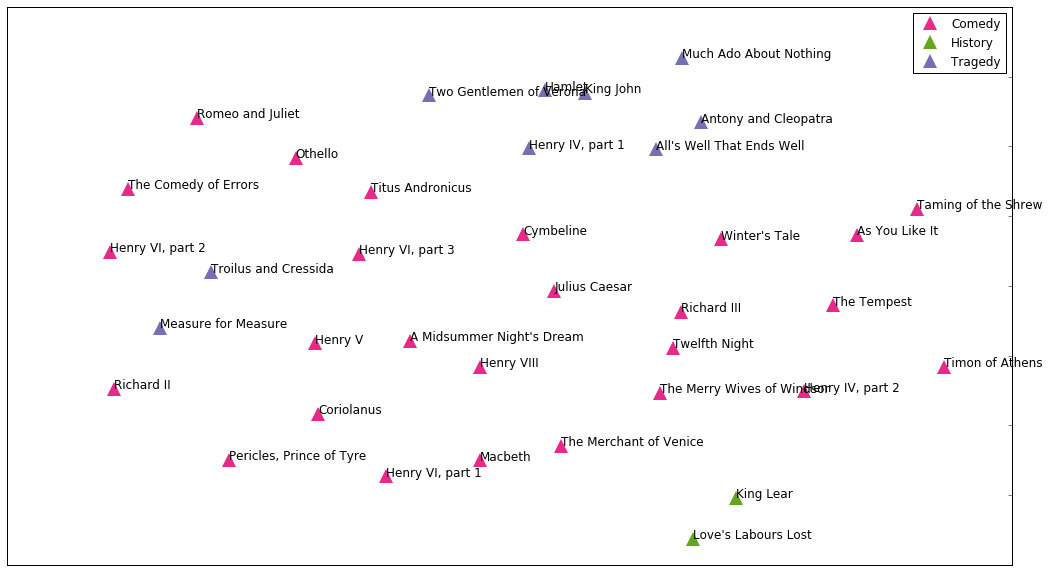

In [32]:
%matplotlib inline 

play_list = [key for key in plays.keys()]

# create data frame that has the result of the MDS plus the cluster numbers and play
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, play_list=play_list)) 

#group by cluster
groups = df.groupby('label')


# set up plot and size it
fig, ax = plt.subplots(figsize=(18, 10))

# iterate through groups to layer the plot, using 
# cluster_name and cluster_color dicts with the 'name'
# lookup to return the appropriate color and label
for name, group in groups:
    ax.plot(group.x, group.y, marker='^', linestyle='', ms=14, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',         # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',        # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the play
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['play_list'], size=12)  


# display the plot
plt.show()
plt.close()

The plays are divided by genre, for our dataset we have 17 comedies, 10 history plays and 10 tragedies. After implementing k-means on the tf-idf transformed play text, with an input of 3 clusters we get clusters that don’t match to the original mapping. We get three clusters of 26, 2 and 9 plays. A problem with k-means is that we’re not sure how these plays are clustered, in the sense that are they clustering to a specific genre or are they clustering based on some other feature. To interpret our results, we visualize our data using Multidimensional Scaling (MDS) and a Dendogram. As stated earlier, the matrices of plays are sparse, so we must apply MDS to reduce this data so that we can visualize it. For visualization purposes, we reduce the dimensions to 2D. Using MDS, we create matrix of similarity of each play to the other using cosine similarity. This reduces a 37 by 7168 matrix to 37 by 37. After we have done this, we apply MDS to reduce the data to two components and transform it so. We then visualize the data, marking the clusters to the best of our ability. From this visualization, we can see that there is some obvious clustering, where the clustered “comedies” are together, with some overlap with “tragedy” cluster. The “history” plays are clustered together and are fairly low in number. The “tragedy” are clustered together and very low in number, with an outlier of Pericles, Prince of Tyre on the far end of the comedy cluster. 

## Using agglomerative hierarchical document clustering:
---

Having performed the clustering using *k-means*, now attempting the *Ward clustering algorithm* based on *hierarchical clustering*. It is *agglomerative*, in the sense that at each stage of a bottom-up process, the pair of clusters with minimum distance between them are merged. We use the earlier computed *cosine distance* matrix (*dist*) to calclate a linkage_matrix, which we use to plot as dendrogram. 

It appears this method is returning 3 primary clusters.

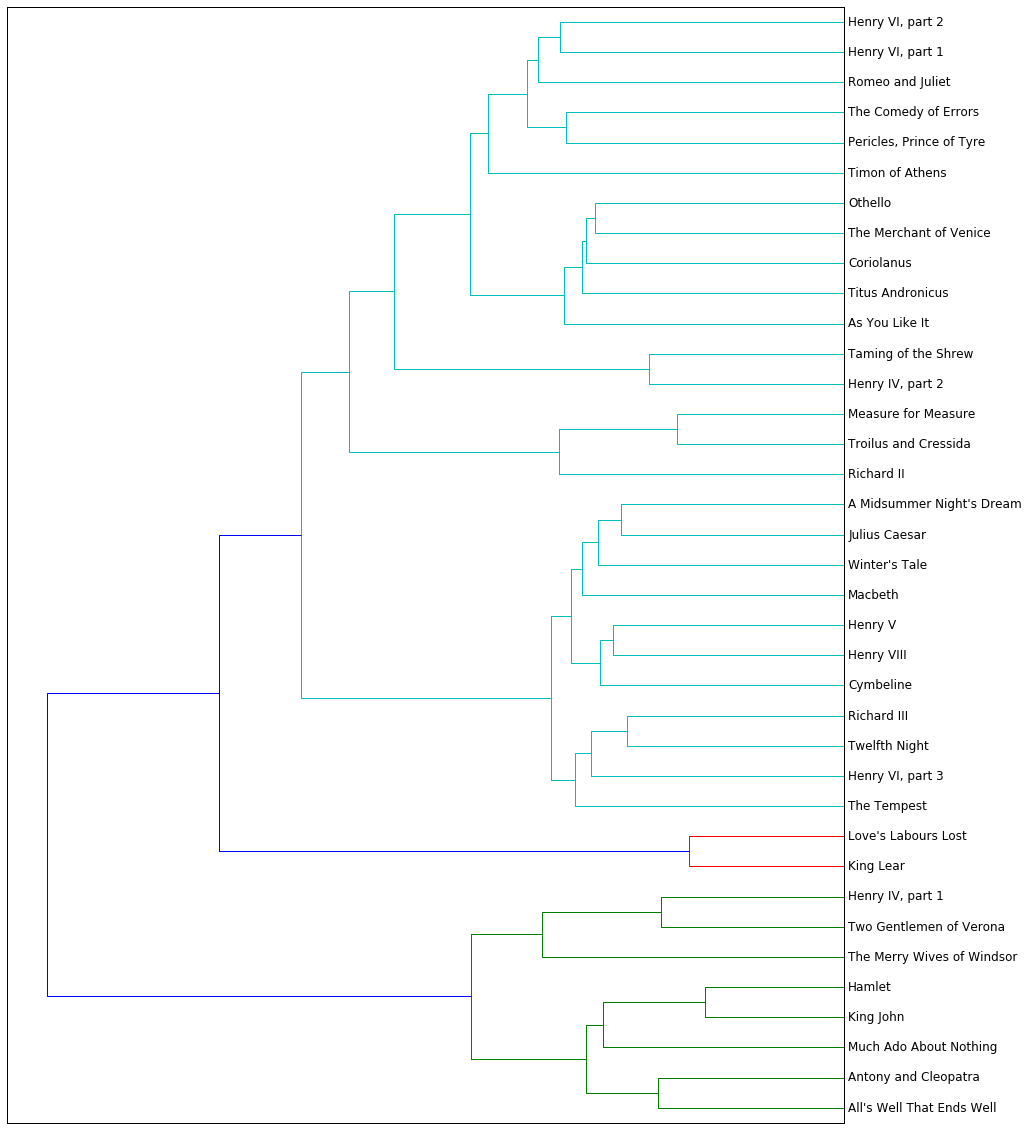

In [33]:
from scipy.cluster.hierarchy import ward, dendrogram

# define the linkage_matrix using ward clustering using eariwer computed distances saved in 'dist'
linkage_matrix = ward(dist) 
#print(linkage_matrix)

play_list = [key for key in plays.keys()]
#print(play_list)

fig, ax = plt.subplots(figsize=(15, 20))
ax = dendrogram(linkage_matrix, orientation="left", labels=play_list, leaf_font_size=12);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')
plt.show()
plt.close()

Having performed the clustering using k-means, we now attempt the Ward clustering algorithm based on hierarchical clustering. It is agglomerative, in the sense that at each stage of a bottom-up process, the pair of clusters with minimum distance between them are merged. We use the earlier computed cosine distance matrix to calculate a linkage matrix, which we use to plot as dendogram. It appears this method is returning 3 primary clusters.

---
## Characterizing similarities and differences between characters as a function of gender:

#### Here we attempt to do classification to seperate the characters by gender.

Now that we have analyzed the genres of the plays, we move on to clustering based on gender of characters. As done earlier, we vectorized the text spoken by all the characters using tf-idf vectorizer and did some exploring on the features of vectorized text. We now similarly apply k-means to this data knowing that there are only two clusters, we hope that this classifies are data as male and female. We apply the same techniques of feature reduction and Multidimensional scaling to reduce the data for visualization using only 2 features. The result is this visual with two clear clusters, one actually encapsulating the other, with the green as female characters and pink as male characters. We see that there is definitely a difference between the original male and female data to what is clustered, in the original data we have 3602 male characters and 198 female characters. Now we get a result of two clusters of 2993 and 807 characters. So there are definitely some misclassifications. 

---
### Computing the TF-IDF:

#### Here, we are computing the term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the *speaker_text* list into a tf-idf matrix. 

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.85, max_features=400000,
                                 min_df=0.15, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,4))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(speaker_df['speaker_text']) #fit the vectorizer to speaker text

CPU times: user 28.8 s, sys: 452 ms, total: 29.2 s
Wall time: 29.4 s


In [35]:
print('Shape: ', tfidf_matrix.shape)
print('\nSparse Matrix:')
print(tfidf_matrix[0,:20])

Shape:  (1335, 156)

Sparse Matrix:
  (0, 1)	0.337595012908


### Terms:  
**The list of the features used in the tf-idf matrix, which is the complete vocabulary for the analysis.**

In [36]:
terms = tfidf_vectorizer.get_feature_names()
print(len(terms))
print(terms[:10])

156
["'d", "'s", "'t", 'ani', 'anoth', 'answer', 'arm', 'art', 'away', 'ay']


### Clustering using K-Means:

Using the tf-idf matrix, we run the **k-means** clustering algorithms to find clustering/similarity between the characters. 

Each character is assigned to a cluster. 

Several runs of the algorithm would be required to converge a global optimum as k-means is susceptible to reaching local optima. 

In [37]:
from sklearn.cluster import KMeans

num_clusters = 2 # doing it for gender - male/female

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 4.24 s, sys: 22.7 ms, total: 4.26 s
Wall time: 4.28 s


In [38]:
print(clusters[2:5])

[0, 1, 1]


---
#### Converting play list and clustering dictionaries to Pandas DataFrame.

In [39]:
pd_speakers_class = character_df[['Speaker','Gender']]
pd_speakers_class.columns = ['speaker','gender']
pd_speakers_class.head()

,speaker,gender
0,HAMLET,Male
1,IAGO,Male
2,KING HENRY,Male
3,OTHELLO,Male
4,TIMON,Male


In [40]:
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

pd_clusters = pd.DataFrame(clusters, columns = ['cluster'])

#pd_speakers_class = pd.DataFrame(character_df['Speaker'])

all_speakers_cluster = pd.concat([speaker_df, pd_clusters], axis=1)[['speaker','play','cluster']]
all_speakers_frame = pd.merge(all_speakers_cluster, pd_speakers_class, on='speaker')[['speaker','play','cluster','gender']]

# print 46th to 50th character classification
all_speakers_frame.sort('gender')[['speaker','play','cluster','gender',]].head(50).tail()

,speaker,play,cluster,gender
2159,CELIA,As You Like It,1,Female
2158,AUDREY,As You Like It,0,Female
3517,MARINA,"Pericles, Prince of Tyre",1,Female
3527,THAISA,"Pericles, Prince of Tyre",0,Female
3536,DUCHESS OF YORK,Richard II,1,Female


In [41]:
#groupby cluster for aggregation purposes
grouped_by_cluster = all_speakers_frame.groupby(all_speakers_frame['cluster']) 

#groupby cluster for aggregation purposes
grouped_by_class = all_speakers_frame.groupby(all_speakers_frame['gender']) 


print('Origninal group count: ', grouped_by_class.count()) #counts per cluster
print('\nClustering group count: ', grouped_by_cluster.count()) #counts per cluster
grouped_by_cluster.head(260).tail()

Origninal group count:          speaker  play  cluster
gender                        
Female      198   198      198
Male       3602  3602     3602

Clustering group count:           speaker  play  gender
cluster                       
0           2993  2993    2993
1            807   807     807


,speaker,play,cluster,gender
2500,LORD,Richard II,1,Male
2501,LORD,Richard II,1,Male
2502,LORD,Richard II,1,Male
2503,LORD,Richard II,1,Male
2504,LORD,Richard II,1,Male


## Multidimensional Scaling:
Defining **dist** as *(1 - the cosine similarity of each document)*, we compute the cosine similarity against the tf-idf matrix to generate a measure of similarity between each document and the other documents in the entire corpus of 37 plays. 

In [42]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [43]:
print(len(dist), len(dist[0]))

1335 1335


### 2-D array of distances:
Next, converting the dist matrix into a 2-dimensional array, using *multidimensional scaling*, that we use further down for vizualizing the clusters and ite members.

In [44]:
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed")
#random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

### Visualizing the clustering output for the three classes:

In [45]:
# set up colors per clusters using a dict
cluster_colors = {0: '#e7298a', 1: '#66a61e', 2: '#7570b3'}

# set up cluster names using dict
cluster_names = {0: 'Male', 
                 1: 'Female'}

### Plotting the labeled plays colored by cluster:

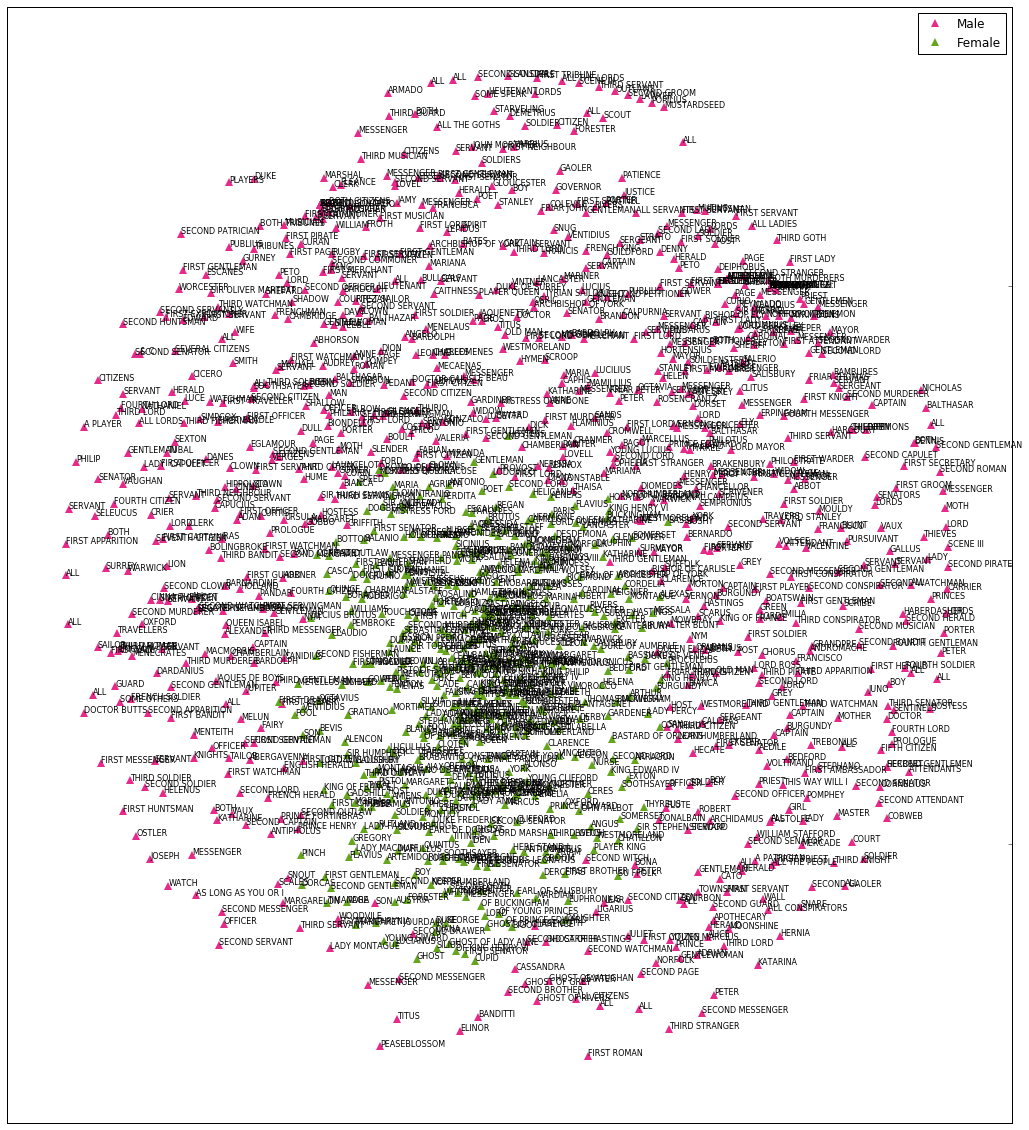

In [46]:
%matplotlib inline 

speakers_list = speaker_df['speaker']
speakers_list.head()

# create data frame that has the result of the MDS plus the cluster numbers and play
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, speakers_list=speakers_list)) 

#group by cluster
groups = df.groupby('label')


# set up plot and size it
fig, ax = plt.subplots(figsize=(18, 20))

# iterate through groups to layer the plot, using 
# cluster_name and cluster_color dicts with the 'name'
# lookup to return the appropriate color and label
for name, group in groups:
    ax.plot(group.x, group.y, marker='^', linestyle='', ms=8, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',         # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',        # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the play
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['speakers_list'], size=8)  


# display the plot
plt.show()
plt.close()

---
## Conclusion:
---

From this analysis, we have concluded that k-means although a very powerful algorithm, has a few drawbacks especially related to this dataset. K-means works best when clusters sizes are the same i.e. all clusters have almost the same number of observations for classifications. This is the reason for many of the misclassifications for the gender roles of the characters in all the plays as the genders of the characters are biased towards men. k-means is also a special case of Gaussian Mixture Models that assumes that shape of these clusters are spherical. This is textual data with different characters, genres, writing styles, thus this is where k-means can possibly fail

---
## Exploratory:
---

After having this paper Determining the Gender of Shakespeare’s Characters by Matt Olson - http://cs229.stanford.edu/proj2013/OlsonDeterminingTheGenderOfShakespearesCharacters.pdf.   
We decided to use a supervised learning method as shown in this paper. Our choice was to use a Naïve Bayes classifier on the gender data to see how that data was classified. So we created test and train sets of the characters gender and the lines they spoke by choosing the first 350 characters for the train and the next 350 for the test set. We vectorized the data using a Count Vectorizer that results in a sparse matrix of 12081 features. After that we applied a tf-idf transformation of the count vectorized data, we did this for both the test and train set and used sklearn Naïve Bayes packages, with MultinomialNB as the classifier. We then test the predictions on a few of the characters and it seems this classified works successfully, the main reason we can test that is that we have labels to check our accuracy with. We get an accuracy score of 85.7%. 

### Clustering using Naïve Bayes classifier:

Using the re-calculated tf-idf matrix, we run the **Naïve Bayes classifier** clustering algorithms to find clustering/similarity between the characters. 

Each character is assigned to a cluster. 

Several runs of the algorithm would be required to converge a global optimum as k-means is susceptible to reaching local optima. 

#### Recalculating TF-TDF:

#### Here, we are computing the term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the *speaker_text* list into a tf-idf matrix. 

In [47]:
pd_speakers_class = character_df[['Speaker','Gender','Play']]
pd_speakers_class.columns = ['speaker','gender','play']
pd_speakers_class.head()
speaker_df.head()

,play,speaker,speaker_text
0,A Midsummer Night's Dream,ALL,"That would hang us, every mother's son. Where..."
1,A Midsummer Night's Dream,BOTTOM,"You were best to call them generally, man by ..."
2,A Midsummer Night's Dream,COBWEB,And I. Hail! Cobweb.
3,A Midsummer Night's Dream,DEMETRIUS,"Relent, sweet Hermia: and, Lysander, yield Th..."
4,A Midsummer Night's Dream,EGEUS,"Happy be Theseus, our renowned duke! Full of ..."


In [48]:
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

all_speakers_frame = pd.merge(speaker_df, 
                              pd_speakers_class, on=['play','speaker'])[['speaker',
                                                                         'play','speaker_text',
                                                                         'gender']]

# print 46th to 50th character classification
all_speakers_frame.sort('gender')[['speaker','play','gender']].head(50).tail()

,speaker,play,gender
580,NERISSA,The Merchant of Venice,Female
581,PORTIA,The Merchant of Venice,Female
171,FIRST LADY,Cymbeline,Female
500,GIRL,Richard III,Female
592,MISTRESS FORD,The Merry Wives of Windsor,Female


In [49]:
# collect all target labels/classifications
train_data = all_speakers_frame[['speaker','play','gender','speaker_text']].head(350)
test_data = all_speakers_frame[['speaker','play','gender','speaker_text']].tail(350)
print(len(train_data))
train_data.head()

350


,speaker,play,gender,speaker_text
0,BOTTOM,A Midsummer Night's Dream,Male,"You were best to call them generally, man by ..."
1,COBWEB,A Midsummer Night's Dream,Male,And I. Hail! Cobweb.
2,DEMETRIUS,A Midsummer Night's Dream,Male,"Relent, sweet Hermia: and, Lysander, yield Th..."
3,EGEUS,A Midsummer Night's Dream,Male,"Happy be Theseus, our renowned duke! Full of ..."
4,FAIRY,A Midsummer Night's Dream,Male,"Over hill, over dale, Thorough bush, thorough..."


In [50]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_data['speaker_text'])
print(X_train_counts.shape)
print(count_vect.vocabulary_.get('moonlight'))

(350, 12081)
6774


In [51]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(350, 12081)

In [52]:
X_test_counts = count_vect.transform(test_data['speaker_text'])
tf_transformer = TfidfTransformer(use_idf=False).fit(X_test_counts)
X_test_tf = tf_transformer.transform(X_test_counts)
X_test_tf.shape

(350, 12081)

### Model Setup:  

In [53]:
from sklearn.naive_bayes import MultinomialNB

train_target_labels = train_data['gender']
%time clf = MultinomialNB().fit(X_train_tf, train_target_labels)
print(clf)

CPU times: user 2.87 ms, sys: 745 µs, total: 3.62 ms
Wall time: 3.55 ms
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


---
### Next, using the model built in previous step, we try few predictions:

In [54]:
predicted = clf.predict(X_test_tf)

In [70]:
from sklearn.metrics import accuracy_score
acc_score = accuracy_score(test_data['gender'], predicted, normalize=False)
print('Accuracy Score: ', acc_score)
print('Accuracy Percent: ', (acc_score*100)/len(predicted))

Accuracy Score:  300
Accuracy Percent:  85.7142857143


In [66]:
for i in [2,5,7,29]:
   #print(test_data[test_data['gender'] == 'Female'].head(200+i).tail(1))
   print('-----------------------------------------------')
   print('Test Input: \n', test_data.head(200+i).tail(1)[['speaker','play','gender']])
   print('\nPredicted Output: \n', predicted[(200+i-1)])
   print('-----------------------------------------------\n\n')

-----------------------------------------------
Test Input: 
       speaker                    play gender
584  STEPHANO  The Merchant of Venice   Male

Predicted Output: 
 Male
-----------------------------------------------


-----------------------------------------------
Test Input: 
       speaker                        play gender
587  BARDOLPH  The Merry Wives of Windsor   Male

Predicted Output: 
 Male
-----------------------------------------------


-----------------------------------------------
Test Input: 
     speaker                        play gender
589  FENTON  The Merry Wives of Windsor   Male

Predicted Output: 
 Male
-----------------------------------------------


-----------------------------------------------
Test Input: 
        speaker         play gender
611  FRANCISCO  The Tempest   Male

Predicted Output: 
 Male
-----------------------------------------------


